# Object-oriented swath profile

In last two sections we have presented using PyOSP to perform traditional fixed- width/radius analysis. Here, we give case studies to introduce proposed methods in PyOSP that can objectively characterize geological structures having complex boundaries and orientations.

The basic concept is to combine geo-classification with swath analysis so that the landform information can be assimilated into the evaluation process. To target the specific topographic feature, PyOSP evaluates the geo-parameter values (e.g., elevation, slope, or topographic position index (TPI)) along the profile line, and truncates the current line development if pixel values exceed user-defined thresholds. The process is iterated along the baseline path according to the *line_stepsize*, which enables PyOSP to collect data from non-linear profiles with irregular boundaries. Figure below illustrates the difference of sampled data between traditional (a) and proposed method (b) from data matrix perspective (min_value=10).

<img alt="homo_case" src="https://i.imgur.com/ufPQW40.jpg" height="250"/>

We use "object-oriented" to name the swath method as the key element here is to objectively define a topographic object through geo-parameter characteriation, which is in contast with previous "functional" approach that is solely parameterized through a fixed- width/radius. The comparison between these two are demonstrated through the syntheric tests as given below.  

## Curvilinear swath analysis

For curvilinear swath illustrative case, we use an artifacial DEM dataset that was used in the first section.

<img alt="homo_case" src="https://i.imgur.com/nSFSqxo.png" height="250"/>

PyOSP offers elevation, slope, and topographic postion index (TPI) based swath methods in both cuvilinear (curvsp) and circular (cirsp) modules. Below gives a simple example for carrying out these geo-parameter aided analyses in curvilinear case.  


In [1]:
import pyosp

baseline = pyosp.datasets.get_path("homo_baseline.shp") # the path to baseline shapefile
raster = pyosp.datasets.get_path("homo_mount.tif")  # the path to raster file

fixed_width = pyosp.Orig_curv(baseline, raster, width=100,
                              line_stepsize=3, cross_stepsize=None)

elev = pyosp.Elev_curv(baseline, raster, width=100,
                       min_elev=0.01,
                       line_stepsize=3, cross_stepsize=None)

slope = pyosp.Slope_curv(baseline, raster, width=100,
                         min_slope=1,
                         line_stepsize=3, cross_stepsize=None)

tpi = pyosp.Tpi_curv(baseline, raster, width=100,
                     tpi_radius=50, min_tpi=0,
                     line_stepsize=3, cross_stepsize=None)

Processing: [#########################] 71 of 71 lineSteps

The code block above generated four swath objects corresponding to original (fixed-width), elevation, slope, and TPI methods, respectively. The default miminum and maximum value thresolds for elevation method are -inf and inf, for slope are 0 and 90, for TPI are -inf are inf. The default *line_stepsize* and *cross_stepsize* equal to the size of raster resolution. TPI based method has an additional parameter *tpi_radius* that controls the size of calculation window. For more information, users are refer to [Weiss, 2001](http://www.jennessent.com/downloads/tpi-poster-tnc_18x22.pdf).

## Swath polygons comparison

In previous section, we have shown the cases of using GDAL to plot the swath polygon on top of raster dataset. Here, we give an example by making use of [rasterio](https://rasterio.readthedocs.io/en/latest/intro.html) to easily generate similar results. Note that PyOSP is not depend on rasterio, so the user needs to [install rasterio](https://rasterio.readthedocs.io/en/latest/installation.html) seperately.

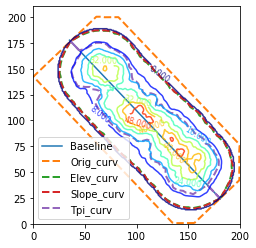

In [2]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# plot the shapely object
def plot_coords(ax, ob, **kwargs):
    x, y = ob.xy
    ax.plot(x, y, zorder=1, **kwargs)

src = rasterio.open(raster)
swath_obs = [fixed_width, elev, slope, tpi]
line_shape = pyosp.read_shape(baseline)

fig, ax = plt.subplots()
show(src.read(), transform=src.transform, ax=ax, contour=True, cmap='jet')
plot_coords(ax=ax, ob=line_shape, label="Baseline")
for ob in swath_obs:
    plot_coords(ax=ax, ob=ob.out_polygon().exterior, 
                linestyle="--", lw=2, label=str(ob))

ax.set_aspect('equal', adjustable='box')
ax.legend()

As shown above, both elevation and slope based methods captured the exact shape of mountain object (elevation > 0). This is achieved by setting the small minimum threshold of 0.01m and 1 degree to differentiate mountain range from surronding ground. The TPI swath goes with contour elevation=16m for a great portion, which essentially delineates the convex up (erosional) slopes from the convex down (depositional slopes) in the topography, offering some interesting insights about the topoghraphic development and could be useful in some analysis.

Let's do some additional sensitivity analysis about the location of baseline. This time we offset the baseline to the left of centeral axis of the mountain. Swath analyses were applied again and generated polygons as below:

Processing: [#########################] 71 of 71 lineSteps

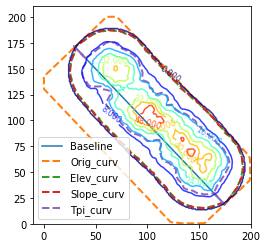

In [3]:
baseline_offset = pyosp.datasets.get_path("homo_baselineOffset.shp") # the path to baseline shapefile
raster = pyosp.datasets.get_path("homo_mount.tif")  # the path to raster file

fixed_width_offset = pyosp.Orig_curv(baseline_offset, raster, width=100,
                                     line_stepsize=3, cross_stepsize=None)

elev_offset = pyosp.Elev_curv(baseline_offset, raster, width=100,
                              min_elev=0.01,
                              line_stepsize=3, cross_stepsize=None)

slope_offset = pyosp.Slope_curv(baseline_offset, raster, width=100,
                                min_slope=1,
                                line_stepsize=3, cross_stepsize=None)

tpi_offset = pyosp.Tpi_curv(baseline_offset, raster, width=100,
                            tpi_radius=50, min_tpi=0,
                            line_stepsize=3, cross_stepsize=None)

swath_offset = [fixed_width_offset, elev_offset, slope_offset, tpi_offset]
line_offset = pyosp.read_shape(baseline_offset)

fig, ax = plt.subplots()
show(src.read(), transform=src.transform, ax=ax, contour=True, cmap='jet')
plot_coords(ax=ax, ob=line_offset, label="Baseline")
for ob in swath_offset:
    plot_coords(ax=ax, ob=ob.out_polygon().exterior, 
                linestyle="--", lw=2, label=str(ob))

ax.set_aspect('equal', adjustable='box')
ax.legend()

It shows that the original swath method creates a polygon offset with the altered baseline, while all geo-parameter based swath polygons are identical to the previous case.This illustrates one of motivations behind about using object- instead of functional-oriented swath methodologies, by truncating the profile lines according to the object's geo-parameter values rather than a fixed-swath width. 

## Swath profile

To compare the swath profiles generated from four methods, we plot them in the same figure.

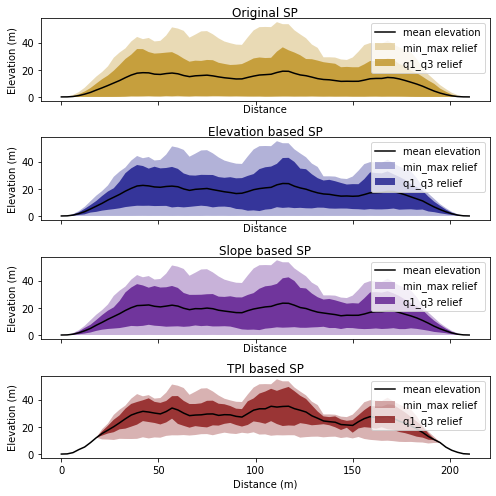

In [4]:
colors = ['darkgoldenrod', 'navy', 'indigo', 'maroon']
titles = ['Original SP', 'Elevation based SP',
          'Slope based SP', 'TPI based SP']

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(7, 7))
# fig.subplots_adjust(hspace=0.2)

for ind, ob in enumerate(swath_obs):
    ob.profile_plot(ax=ax[ind], color=colors[ind])
    ax[ind].set_title(titles[ind], pad=2)
    ax[ind].set_ylabel("Elevation (m)")
    ax[ind].legend()
    
    if ind == len(swath_obs)-1:
        ax[ind].set_xlabel('Distance (m)')

The swath profiles show that the elvation mean, 3rd quartile, and the maximum elevations for the traditional, elevation based, and slope based methods are nominally similar. The lower bounds (1st quartile) for the traditional swath are overly smooth and generally match the minimum elevation line due to the inclusion of the surrounding ground surface area. The TPI based swath profiles have the same maximum elevation lines as the other methods, but the rest of the profile statistics are significantly different, due to the threshold value used only capturing the ranges upper slopes and ridges, the erosional convex-up areas.

## Circular swath analysis

<img alt="homo_cir" src="https://i.imgur.com/VYQPVTj.png" height="250"/>

Synthetic topography of a depression was created to evaluate PyOSP geo-parameter based circular swath method. Note that traditional fixed-radius swath (circular) is similar to fixed-width method (curvilinear) except profile lines are following radial directions stemmed from a swath center. **PyOSP proposes a method that extend the profile line from the user-defined centroid to the highest elevation along its path, then continue beyond that elevation peak until the geo-parameter thresold or *radius* is reached.** As a result, only a minimum value is required for each geo-parameter based method. In the example below, the crater impacted radius is around 80m, and the parameters for different methods are listed in the table.


<img alt="homo_cir" src="https://i.imgur.com/U1rAevV.png" height="100"/>


In [ ]:
# restart the kernel
import os
os._exit(00)


In [1]:
import pyosp

center = pyosp.datasets.get_path("center.shp") # the path to baseline shapefile
raster = pyosp.datasets.get_path("crater.tif")  # the path to raster file

fixed_radius = pyosp.Orig_cir(center, raster, radius=80,
                            ng_start=0, ng_end=300,
                            ng_stepsize=1, radial_stepsize=None)

elev = pyosp.Elev_cir(center, raster, radius=80,
                      min_elev=4,
                      ng_start=0, ng_end=300,
                      ng_stepsize=1, radial_stepsize=None)

slope = pyosp.Slope_cir(center, raster, radius=80,
                        min_slope=10,
                        ng_start=0, ng_end=300,
                        ng_stepsize=1, radial_stepsize=None)

tpi = pyosp.Tpi_cir(center, raster, radius=80,
                    tpi_radius=50, min_tpi=2,
                    ng_start=0, ng_end=300,
                    ng_stepsize=1, radial_stepsize=None)

Processing: [#########################] 300 of 300 lineSteps

## Swath polygons comparison

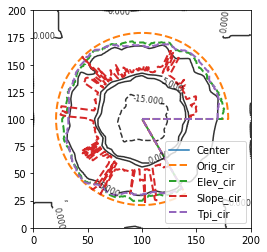

In [2]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# plot the shapely object
def plot_coords(ax, ob, **kwargs):
    x, y = ob.xy
    ax.plot(x, y, zorder=2, **kwargs)

src = rasterio.open(raster)
swath_obs = [fixed_radius, elev, slope, tpi]
center_shape = pyosp.read_shape(center)

fig, ax = plt.subplots()
plot_coords(ax=ax, ob=center_shape, label="Center")
for ob in swath_obs:
    plot_coords(ax=ax, ob=ob.out_polygon().exterior, 
                linestyle="--", lw=2, label=str(ob))

show(src.read(), transform=src.transform, ax=ax, contour=True, 
     levels=[-15, 0, 5], colors='k')
ax.set_aspect('equal', adjustable='box')
ax.legend(loc=4)

As shown above, the traditional fixed-radius swath includes a significant proportion of irrelevant data. Elevation and TPI based methods correctly delineate the irregular boundary of the crater (contour lines of 5m), while slope based polygon is erratic with classification being limited by the sloping rim of the depression or the maximum radial length.

## Swath profile

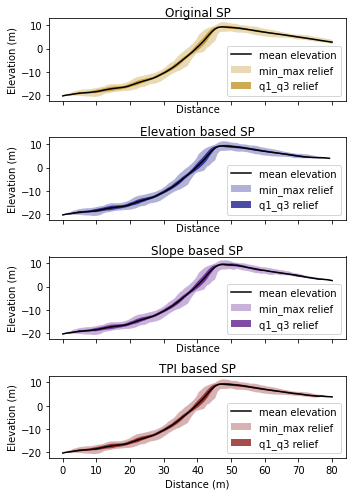

In [3]:
colors = ['darkgoldenrod', 'navy', 'indigo', 'maroon']
titles = ['Original SP', 'Elevation based SP',
          'Slope based SP', 'TPI based SP']

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(5, 7))
# fig.subplots_adjust(hspace=0.2)

for ind, ob in enumerate(swath_obs):
    ob.profile_plot(ax=ax[ind], color=colors[ind])
    ax[ind].set_title(titles[ind], pad=2)
    ax[ind].set_ylabel("Elevation (m)")
    ax[ind].legend()
    
    if ind == len(swath_obs)-1:
        ax[ind].set_xlabel('Distance (m)')

Swath profiles for all methods applied to the homogeneous crater are similar due to the circular setting of the crater and the tight bounds of the maximum allowable radius. However, for characterizing real-world complex topographic boundaries, the choice of swath method will depend on specific working condition and his/her knowledge about the studying object. 

[//]: # (add paper references)

## Summary

Here, we presented geo-parameter based swath analyses through the application on synthetic mountain and crater cases. The objective delineation of topographic objects increases swath profile precision; enabling reproducibility at a higher level than previous approaches. Note that PyOSP also has a rich selection of post-processing functionalities and currently supports, but is not limited to, cross swath, data categprozation and filtering, slce, histogram, and scatter swath plotting using simple and efficient workflows. For more information, the users can refer to our tutorial and library API.

[//]: # (add links)